In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import unidecode

from datetime import datetime, timedelta
from fuzzywuzzy import fuzz
from matplotlib import ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

/home/erick/.local/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
x = os.listdir("Data")
x.sort()
x

['customers_dataset.csv',
 'geolocation_dataset.csv',
 'order_items_dataset.csv',
 'order_payments_dataset.csv',
 'order_reviews_dataset.csv',
 'orders_dataset.csv',
 'product_category_name_translation.csv',
 'products_dataset.csv',
 'sellers_dataset.csv']

In [4]:


#Not unique
Geolocation = pd.read_csv("Data/geolocation_dataset.csv").drop_duplicates()



In [5]:
duplicated = (Geolocation
              .groupby("geolocation_zip_code_prefix")
              .agg({"geolocation_state": "unique"})
              .reset_index()
              .assign(length = lambda df: df.geolocation_state.apply(len))
              .sort_values(by="length", ascending=False)
             )
duplicated.head(10)


,geolocation_zip_code_prefix,geolocation_state,length
16146,79750,"[MS, RS]",2
15879,78557,"[MT, RO]",2
14664,72915,"[GO, DF]",2
1668,4011,"[SP, AC]",2
367,2116,"[SP, RN]",2
6696,23056,"[RJ, AC]",2
16256,80630,"[PR, SC]",2
6506,21550,"[RJ, AC]",2
12677,62010,[CE],1
12676,62000,[CE],1


In [6]:
x = (duplicated
     .query("length != 2")
     [["geolocation_zip_code_prefix"]]
     .merge(Geolocation)
     .groupby("geolocation_state")
     .agg({"geolocation_zip_code_prefix": ["min", "max"]})
     .reset_index()
    )
x.columns = ["geolocation_state", "min", "max"]
x.sort_values(by="max")

,geolocation_state,min,max
25,SP,1001,19990
18,RJ,20010,28999
7,ES,29001,29985
10,MG,30001,39999
4,BA,40010,48990
24,SE,49000,49995
15,PE,50010,56980
1,AL,57000,57995
14,PB,58010,58995
19,RN,53012,59995


The Zip codes are well ordered by state except for DF and GO, I'll classify the zip codes with two geolocation_states based on the minimum and maximum ranges within the state and there's just one zip_code that I had to google it and classify it

In [7]:
Geolocation = (
    Geolocation
    .merge(duplicated
           .query("length > 1")
           [["geolocation_zip_code_prefix"]])
    .drop(columns="geolocation_state")
    .assign(F=1)
    .merge(x.assign(F = 1)) 
    .query("geolocation_zip_code_prefix >= min and geolocation_zip_code_prefix <= max")
    .assign(geolocation_state = lambda df: df.apply(lambda row: ("GO" 
                                                                 if row.geolocation_zip_code_prefix == 72915 else 
                                                                 row.geolocation_state)
                                                    , axis=1))
    .drop(columns=["F", "min", "max"])
    .append(Geolocation
            .merge(duplicated
                   .query("length == 1")
                   [["geolocation_zip_code_prefix"]]))
)

Let's plot Brazil:

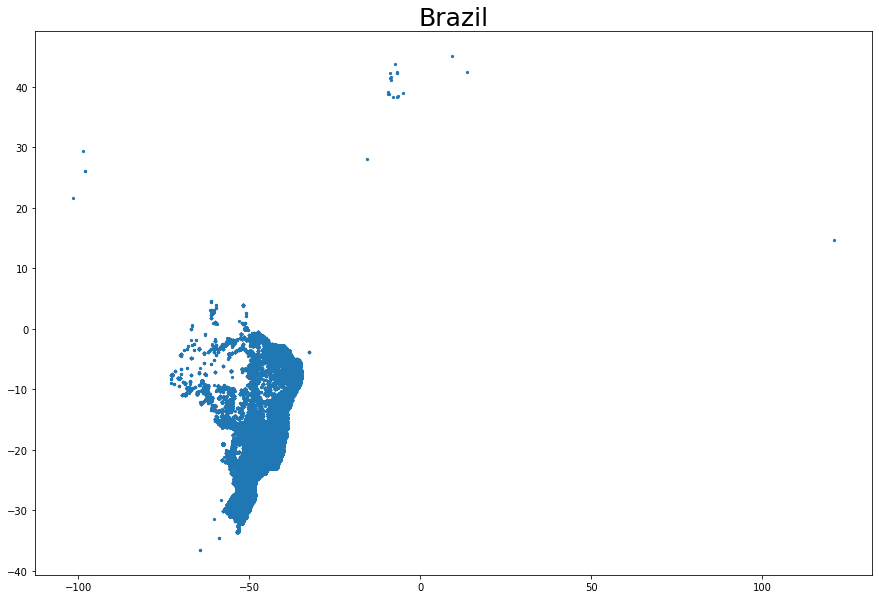

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Geolocation.geolocation_lng, Geolocation.geolocation_lat, s=5)
ax.set_title("Brazil", fontsize=25)
plt.show()

Well, that exactly doesn't seem like Brazil. So I'll have to clean some points. What's the range for brazilian coordinates? [Wiki](https://en.wikipedia.org/wiki/Geography_of_Brazil#Size_and_geographical_location) says that north to south 5°16'20" N to -33°44'32" S and east to west -34°47'30" E to -73°59'32" W. So in our decimal range:

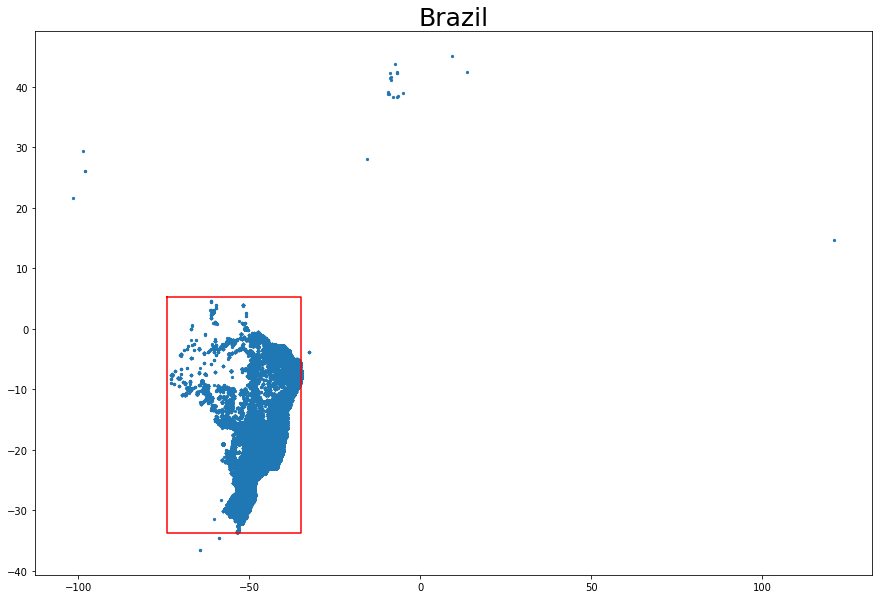

In [9]:
y_max = 5 + 16/60 + 20/3600
y_min = -(33 + 44/60 + 32/3600)
x_max = -(34 + 47/60 + 30/3600)
x_min = -(73 + 59/60 + 32/3600)

fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Geolocation.geolocation_lng, Geolocation.geolocation_lat, s=5)
ax.plot([x_min, x_max, x_max, x_min, x_min], [y_max, y_max, y_min, y_min, y_max], color="red")
ax.set_title("Brazil", fontsize=25)
plt.show()

Maybe we can extend a little our maximum x

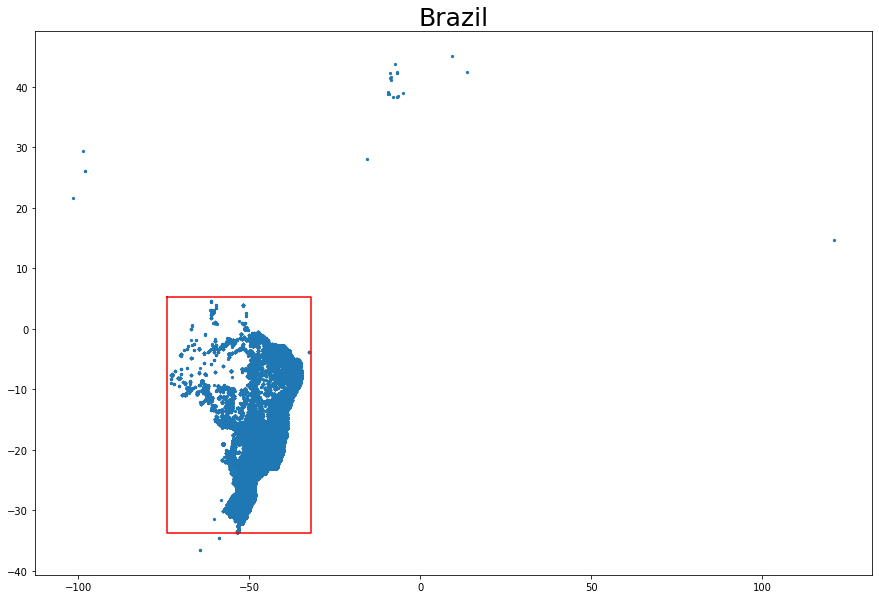

In [10]:
x_max += 3
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Geolocation.geolocation_lng, Geolocation.geolocation_lat, s=5)
ax.plot([x_min, x_max, x_max, x_min, x_min], [y_max, y_max, y_min, y_min, y_max], color="red")
ax.set_title("Brazil", fontsize=25)
plt.show()

Let's check those outliers:

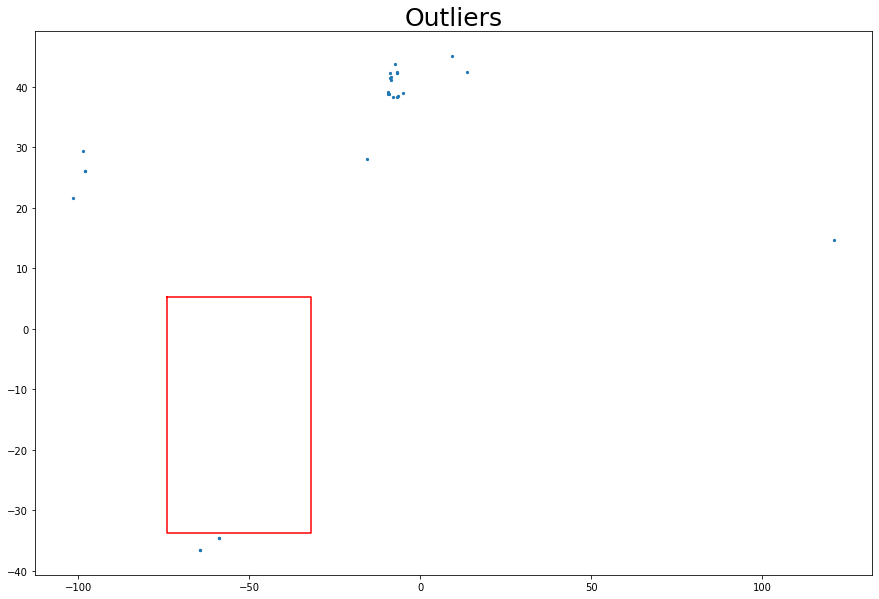

In [11]:
Geolocation = (Geolocation
               .assign(outlier = lambda df: df.apply(lambda row: not (x_min <= row.geolocation_lng <= x_max 
                                                                      and 
                                                                      y_min <= row.geolocation_lat <= y_max)
                                                     , axis=1))
              )

fig, ax = plt.subplots(figsize=(15,10))
Outliers = Geolocation.query("outlier")
ax.scatter(Outliers.geolocation_lng, Outliers.geolocation_lat, s=5)
ax.plot([x_min, x_max, x_max, x_min, x_min], [y_max, y_max, y_min, y_min, y_max], color="red")
ax.set_title("Outliers", fontsize=25)
plt.show()

In [12]:
Outliers.geolocation_zip_code_prefix.nunique()

20

There are just 20 outliers, so I will check if the zip code has another valid (long, lat) since it's not an unique column.

In [13]:
Outliers_Found = (Geolocation
                  .query("not outlier")
                  .merge(Outliers[["geolocation_zip_code_prefix"]].drop_duplicates())
                  [["geolocation_zip_code_prefix"]]
                  .drop_duplicates()
                  .assign(found = 1)
                 )
Outliers_Found

,geolocation_zip_code_prefix,found
0,28165,1
3,28155,1
6,28333,1
11,28595,1
19,29654,1
21,35179,1
86,45936,1
116,46560,1
117,47310,1
121,57319,1


There are 16 values within the zip code I could assign, so I will asign the outliers between the previous and consecutive zip codes remaining. Also I will calculate the geometric center of the zip codes:

In [14]:
Geolocation = (Geolocation
               .merge(Outliers_Found, how="left")
               .query("found != found or not outlier")
              )

In [15]:
Centroids = (Geolocation
             .groupby(["geolocation_zip_code_prefix", "geolocation_state", "outlier"])
             .agg({"geolocation_lat": "mean"
                   , "geolocation_lng": "mean"})
             .reset_index()
             .assign(R = lambda df: range(df.shape[0]))
            )
Centroids

,geolocation_zip_code_prefix,geolocation_state,outlier,geolocation_lat,geolocation_lng,R
0,1001,SP,False,-23.550227,-46.634039,0
1,1002,SP,False,-23.547657,-46.634991,1
2,1003,SP,False,-23.549000,-46.635582,2
3,1004,SP,False,-23.549829,-46.634792,3
4,1005,SP,False,-23.549547,-46.636406,4
...,...,...,...,...,...,...
19010,99960,RS,False,-27.953722,-52.025511,19010
19011,99965,RS,False,-28.183372,-52.039850,19011
19012,99970,RS,False,-28.343920,-51.874988,19012
19013,99980,RS,False,-28.389500,-51.843122,19013


In [16]:
Outliers = (Centroids
            .query("outlier")
            .assign(previous = lambda df: df.R-1
                    , consecutive = lambda df: df.R+1)
            [["geolocation_zip_code_prefix", "geolocation_state", "previous", "consecutive"]]
            .merge(Centroids
                   .rename(columns={"geolocation_lat": "lat_0"
                                    , "geolocation_lng": "lng_0"
                                    , "R": "previous"})
                   .drop(columns=["outlier", "geolocation_zip_code_prefix"])
                   , how="left")
            .merge(Centroids
                   .rename(columns={"geolocation_lat": "lat_1"
                                    , "geolocation_lng": "lng_1"
                                    , "R": "consecutive"})
                   .drop(columns=["outlier", "geolocation_zip_code_prefix"])
                   , how="left")
            .assign(geolocation_lat = lambda df: (df.lat_0 + df.lat_1)/2
                    , geolocation_lng = lambda df: (df.lng_0 + df.lng_1)/2)
            [["geolocation_zip_code_prefix", "geolocation_state", "geolocation_lat", "geolocation_lng"]]
           )
Outliers

,geolocation_zip_code_prefix,geolocation_state,geolocation_lat,geolocation_lng
0,18243,SP,-23.533785,-48.421635
1,78131,MT,-15.674373,-56.142867
2,83252,PR,-25.595896,-48.526932
3,95130,RS,-29.250197,-51.061758


Just for visualizing the outliers:

In [17]:
Centroids = (Centroids
             .query("not outlier")
             .drop(columns=["R", "outlier"])
             .append(Outliers)
            )

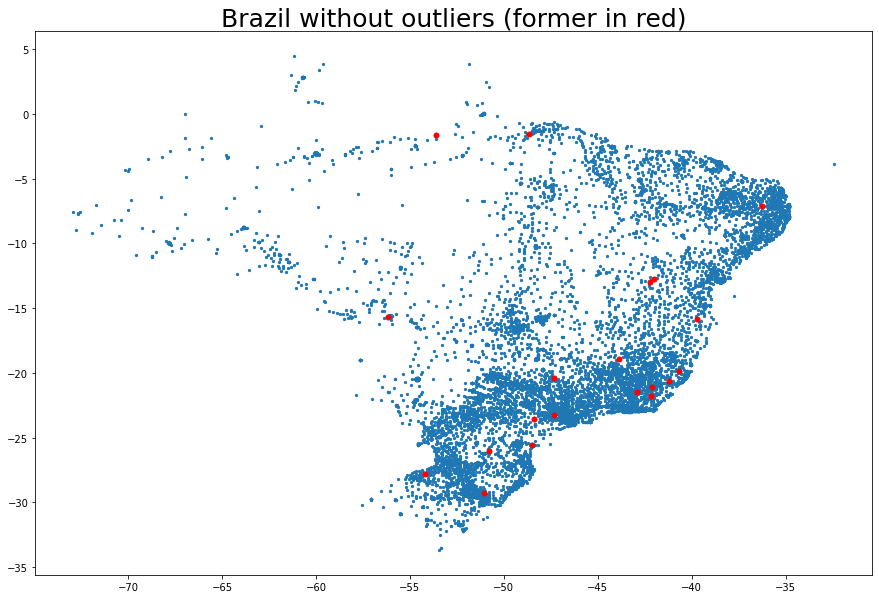

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(Centroids.geolocation_lng, Centroids.geolocation_lat, s=5)
temp = Centroids.merge(Outliers_Found)
ax.scatter(temp.geolocation_lng, temp.geolocation_lat, s=25, color="red")
ax.scatter(Outliers.geolocation_lng, Outliers.geolocation_lat, s=25, color="red")
ax.set_title("Brazil without outliers (former in red)", fontsize=25)
plt.show()

My first approach was to cluster sellers based on latitude and longitude and then score the clients with these clusters. But that would not be very effective, I mean, maybe I would assign a flower specialized seller to a car lover client just because they're near.

So my next approach is going to be to calculate in which category every seller is specialized to assign to a client that likes the most such categories.